![alt text](path_to_banner_image.jpg)
# Title
Author: Elijah Lopez

## Overview


## Business Problem


## Data

In [143]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Inferential Statistical Tests
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
"""
Helper Function to:
    Replace spaces with underscoress
    Make all columns lowercase
"""
def standardize_columns(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

## Data

In [118]:
# Leads
leads = pd.read_csv('data/location_1/leads.csv')
leads = standardize_columns(leads)

# # Accounts
# accounts = pd.read_csv('data/location_1/accounts.csv')
# accounts = standardize_columns(accounts)

# # Students
# students = pd.read_csv('data/location_1/students.csv')
# students = standardize_columns(students)

In [119]:
# Inspect Contents
leads.head()

,created_date,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
0,10/11/2021,0,Mail Only,Unconverted,Female,7,Internet
1,2/14/2022,1,Assessed,Converted,NaN,NaN,Not Specified
2,10/19/2021,2,Assessed,Converted,NaN,NaN,Not Specified
3,2/6/2019,0,Open,Unconverted,NaN,NaN,Internet
4,7/28/2021,0,Contacted,Unconverted,Male,12,Location


In [120]:
# See shape of df
leads.shape

(1533, 7)

In [121]:
# Replace 0 for NaN in zipcodes
leads['zip_code'].replace(0, np.NaN, inplace=True)

In [122]:
# View Data Types
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   created_date       1533 non-null   object 
 1   zip_code           541 non-null    float64
 2   lead_status        1497 non-null   object 
 3   conversion_status  1533 non-null   object 
 4   student_gender     374 non-null    object 
 5   grade              806 non-null    object 
 6   lead_source        1533 non-null   object 
dtypes: float64(1), object(6)
memory usage: 84.0+ KB


In [123]:
# Count nulls -- Note: some still exist as non 'null' values
leads.isna().sum()

created_date            0
zip_code              992
lead_status            36
conversion_status       0
student_gender       1159
grade                 727
lead_source             0
dtype: int64

In [124]:
# Not very helpful for zipcodes
leads.describe()

,zip_code
count,541.000000
mean,7.517560
std,7.542114
min,1.000000
25%,2.000000
50%,5.000000
75%,9.000000
max,42.000000


There are 1,533 leads with 7 features. The 

* created_date - Should be tranformed to datetime
* zip_code - Masked for anonyminity. 0 Represents null values.
* lead_status - 36 untracked leads
* conversion_status - No nulls
* student_gender - Most nulls (1,159), indicating this data is not collected consistently upon initial lead contact
* grade - 727 null values; 'college' and 'k' are forcing string type. Convert to integers.
* lead_source - Nulls represented as 'Not Specified'

## Data Cleaning & Feature Engineering

In [125]:
# Transform created_date to datetime and make index
leads['created_date'] = pd.to_datetime(leads['created_date'])
leads.sort_values(by='created_date', ascending=True, inplace=True)
leads.set_index('created_date', inplace=True)

In [126]:
# Calculate date range of data
min_date = leads.index.min().strftime('%Y-%m-%d')
max_date = leads.index.max().strftime('%Y-%m-%d')
print(f'The data includes leads from {min_date} to {max_date}.')

The data includes leads from 2011-08-11 to 2024-12-09.


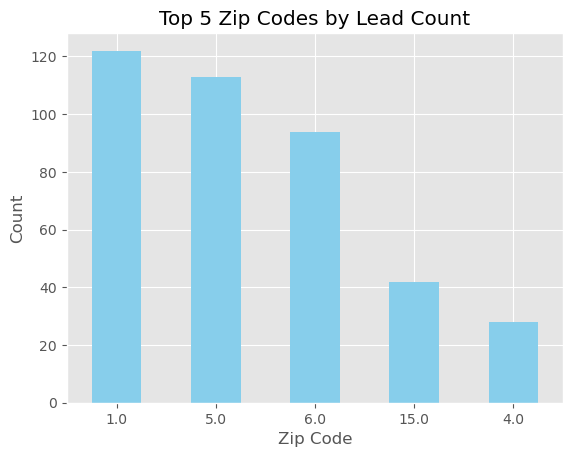

In [127]:
# Top 5 Zip Codes by Lead Volume
top_zip_codes_count = leads['zip_code'].value_counts().nlargest(5)

# Plot
top_zip_codes_count.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Top 5 Zip Codes by Lead Count')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show();

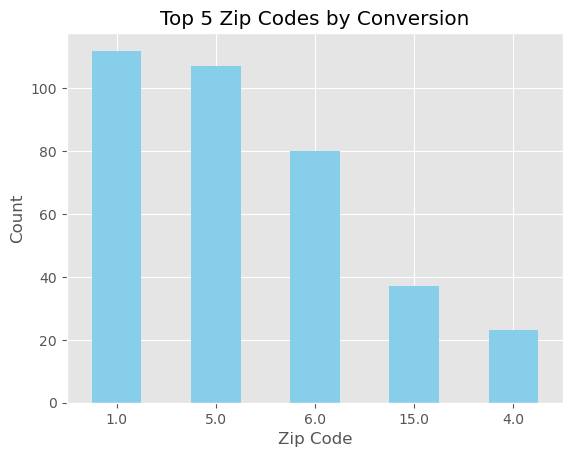

In [128]:
# Isolate Converted Leads
converted_leads = leads.loc[leads['conversion_status'] == 'Converted']

# Top 5 Zip Codes by Conversion
top_zip_codes_converted = converted_leads['zip_code'].value_counts().nlargest(5)

# Plot
top_zip_codes_converted.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Top 5 Zip Codes by Conversion')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show();

Zip Code Counts for converted leads is almost identical to the Zip Code Count for all Leads. This indicates that this information is likely captured after the enrollment, not during initial lead contact.

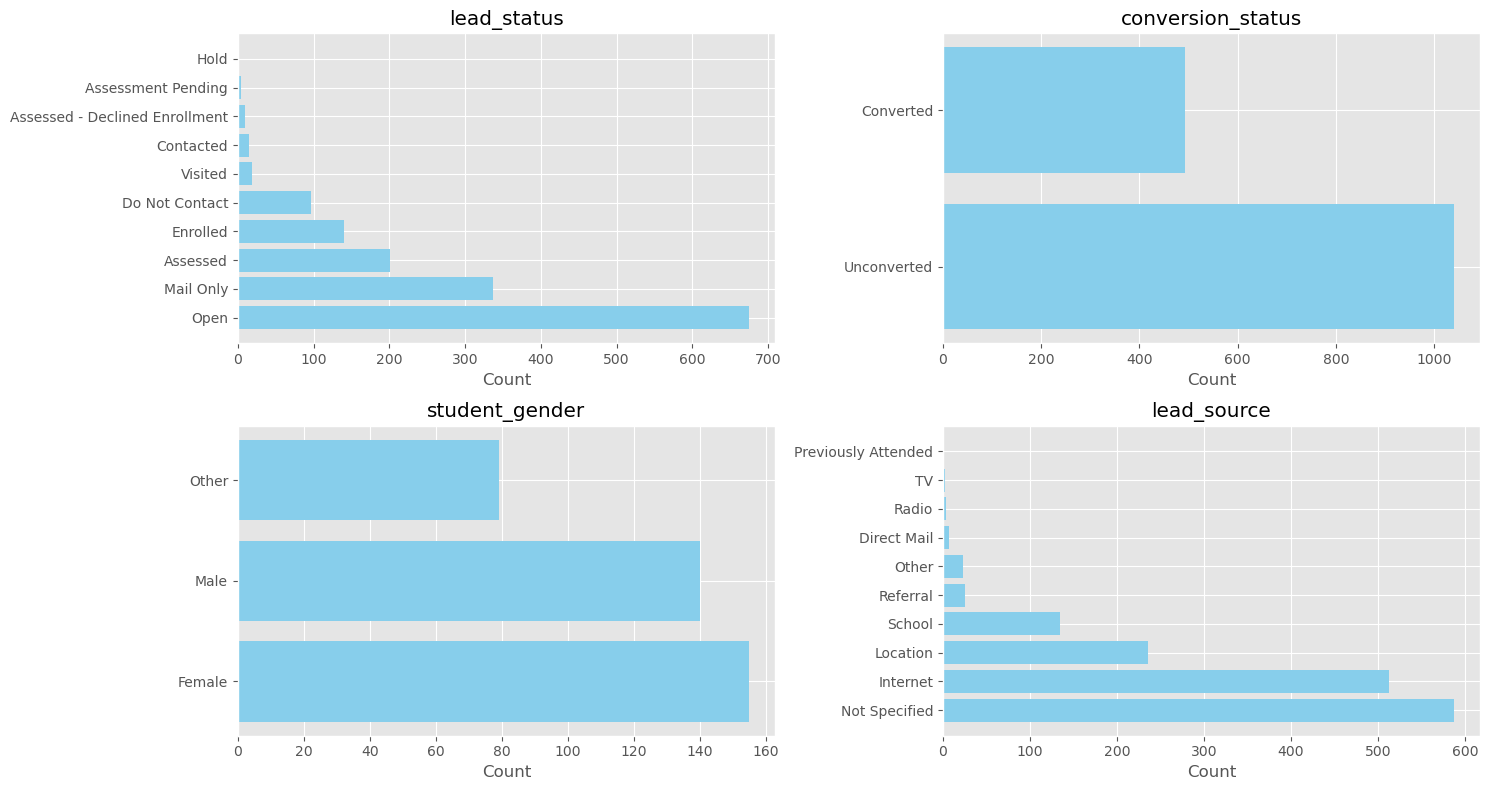

In [129]:
# Identify categorical columns
cat_cols = ['lead_status', 'conversion_status', 'student_gender', 'lead_source']

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

# Apply to each column
for i, column in enumerate(cat_cols):
    x = leads[column].value_counts().index
    y = leads[column].value_counts().values
    
    # Horizontal bar plots
    axes[i].barh(x, y, color='skyblue')
    
    # Add title and labels
    axes[i].set_title(column)
    axes[i].set_xlabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout();

In [130]:
# Calculate overall lead conversion
lead_conversion = len(leads.loc[leads['conversion_status'] == 'Converted']) / len(leads) * 100
print(f'Lead conversion: {lead_conversion:.0f}%')

Lead conversion: 32%


In [131]:
# Group leads by month
monthly_leads = leads['conversion_status'].resample('M').count()    # Use conversion_status because it has no nulls
monthly_leads.index = pd.to_datetime(monthly_leads.index)
monthly_leads

created_date
2011-08-31     1
2011-09-30     0
2011-10-31     0
2011-11-30     0
2011-12-31     0
              ..
2024-08-31    13
2024-09-30    25
2024-10-31    16
2024-11-30    19
2024-12-31     4
Freq: M, Name: conversion_status, Length: 161, dtype: int64

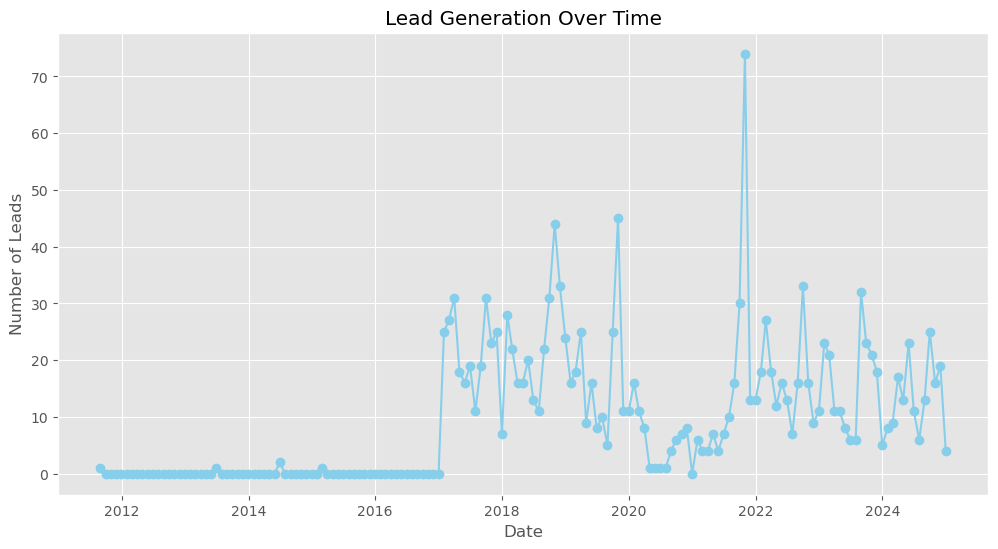

In [132]:
# Plot monthly leads over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_leads.index, monthly_leads.values, marker='o', linestyle='-', color='skyblue')

# Add title and labels
plt.title('Lead Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Leads')
plt.grid(True)
plt.show();

It looks like leads prior to 2017 were extremely low on a monthly basis. Let's focus on more recent years where the data is more consistent.

In [133]:
# Filter date >= 2017-01-01 and group by month
filtered_monthly_leads = monthly_leads[monthly_leads.index >= '2017-01-01']

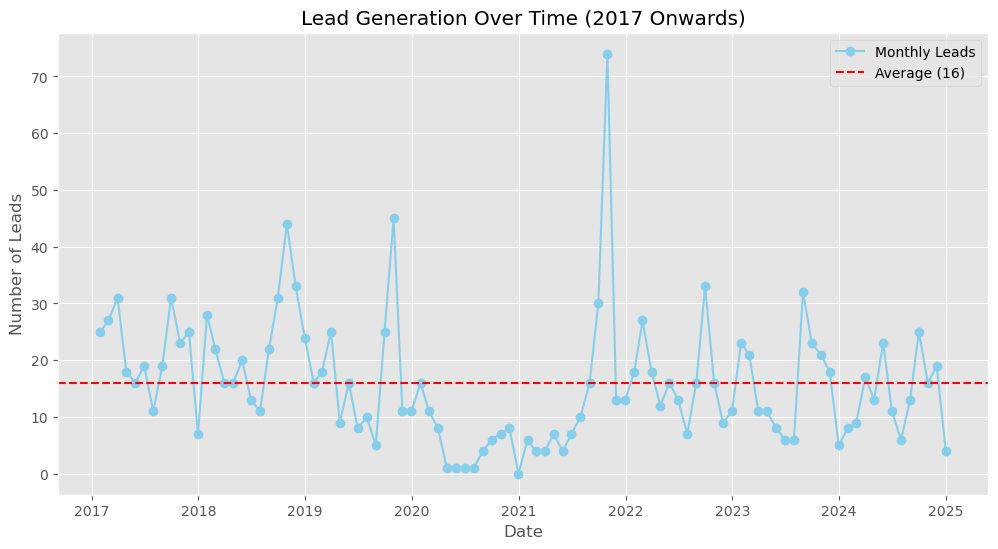

In [134]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(filtered_monthly_leads.index, filtered_monthly_leads.values, marker='o', linestyle='-', color='skyblue', label='Monthly Leads')

# Calculate and plot the mean
average_leads = filtered_monthly_leads.mean()
plt.axhline(y=average_leads, color='red', linestyle='--', label=f'Average ({average_leads:.0f})')

# Add title, labels, and legend
plt.title('Lead Generation Over Time (2017 Onwards)')
plt.xlabel('Date')
plt.ylabel('Number of Leads')
plt.legend()
plt.grid(True)
plt.show();

Next lets look at average lead volume per month

In [135]:
# Create a 'month' column and set equal to 3 letter abbreviation
filtered_monthly_leads = filtered_monthly_leads.to_frame()
filtered_monthly_leads['month'] = filtered_monthly_leads.index.month_name().str[:3]
filtered_monthly_leads.rename(columns={'conversion_status': 'lead_count'}, inplace=True)

# Group by month and calculate the mean for each
monthly_mean = filtered_monthly_leads.groupby('month').mean()

monthly_mean

,lead_count
month,
Apr,10.875
Aug,15.875
Dec,9.375
Feb,17.375
Jan,17.500
Jul,7.750
Jun,9.750
Mar,16.250
May,13.000


<Figure size 1000x600 with 0 Axes>

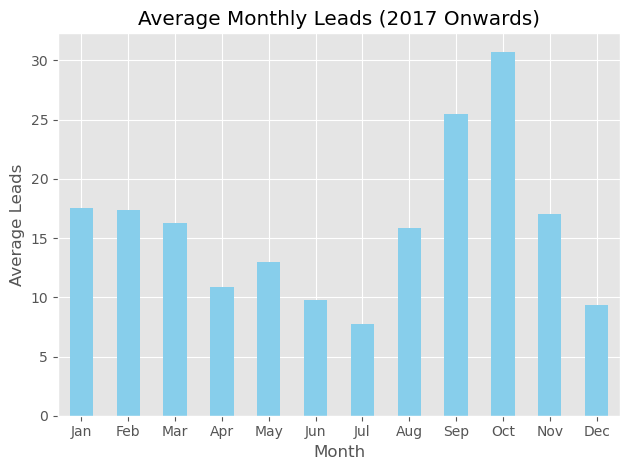

In [136]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_mean = monthly_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
monthly_mean.plot(kind='bar', color='skyblue', legend=False)

# Add title and labels
plt.title('Average Monthly Leads (2017 Onwards)')
plt.xlabel('Month')
plt.ylabel('Average Leads')
plt.xticks(rotation=0)
plt.tight_layout();

These graphs show a cyclical pattern where lead interest peaks in October (roughly corresponding with the end of the 1st quarter) and dropping to its lowest during July (middle of summer).

#### ANOVA & Tukey's HSD

Because I am comparing multiple groups I will conduct an ANOVA test.
* H0: There is not a significant difference in lead volume for different months of the year.
* H1: There is a significant difference in lead volume for different months of the year.
* Alpha = 0.05

In [ ]:
def perform_anova(df, group_col, value_col, alpha):
    """
    Performs a one-way ANOVA test to compare means across groups.
    
    Parameters:
        df (pd.dfFrame) - The data containing the groups and values.
        group_col (str) - The column name representing the groups
        value_col (str) - The column name representing the values to compare
        alpha (float) - Confidence level
    
    Returns:
        dict: A dictionary containing the F-Statistic, P-Value, and interpretation
    """
    # Group the df by the specified group column
    grouped = df.groupby(group_col)[value_col]
    
    # Extract values for each group into separate lists
    grouped_values = [grouped.get_group(group).values for group in grouped.groups.keys()]
    
    # Perform ANOVA test
    f_stat, p_value = f_oneway(*grouped_values)
    
    # Interpretation
    result = {
        "F-Statistic": f_stat,
        "P-Value": p_value,
        "Significance": "Reject the null in favor of the alterantive hypothesis."
        if p_value < 0.05 else "Fail to reject the null hypothesis."
    }
    
    return result

In [ ]:
# Run ANOVA Test
perform_anova(filtered_monthly_leads, 'month', 'lead_count', 0.05)

{'F-Statistic': 3.9133077098047915,
 'P-Value': 0.00013816510470666737,
 'Significance': 'Reject the null in favor of the alterantive hypothesis.'}

In [141]:
def perform_tukeys_hsd(df, group_col, value_col, alpha):
    """
    Perform Tukey's HSD test to determine significant differences between groups.

    Parameters:
        df (pd.DataFrame) - The data containing the groups and values.
        group_col (str) - The column representing groups (e.g., 'month').
        value_col (str) - he column representing the dependent variable (e.g., 'lead_count').
        alpha (float) - Confidence level

    Returns:
        results: Tukey HSD test results.
    """
    tukey = pairwise_tukeyhsd(
        endog=df[value_col],  # The dependent variable
        groups=df[group_col],  # The grouping variable
        alpha=alpha  # Significance level
    )
    print(tukey)
    return tukey


In [148]:
# Follow up with Tukey's HSD
tukey_results = perform_tukeys_hsd(filtered_monthly_leads, 'month', 'lead_count', 0.05)
tukey_results

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   Apr    Aug      5.0 0.9963 -11.1917 21.1917  False
   Apr    Dec     -1.5    1.0 -17.6917 14.6917  False
   Apr    Feb      6.5 0.9696  -9.6917 22.6917  False
   Apr    Jan    6.625 0.9651  -9.5667 22.8167  False
   Apr    Jul   -3.125    1.0 -19.3167 13.0667  False
   Apr    Jun   -1.125    1.0 -17.3167 15.0667  False
   Apr    Mar    5.375 0.9931 -10.8167 21.5667  False
   Apr    May    2.125    1.0 -14.0667 18.3167  False
   Apr    Nov    6.125 0.9805 -10.0667 22.3167  False
   Apr    Oct   19.875 0.0046   3.6833 36.0667   True
   Apr    Sep   14.625 0.1163  -1.5667 30.8167  False
   Aug    Dec     -6.5 0.9696 -22.6917  9.6917  False
   Aug    Feb      1.5    1.0 -14.6917 17.6917  False
   Aug    Jan    1.625    1.0 -14.5667 17.8167  False
   Aug    Jul   -8.125  0.869 -24.3167  8.0667  False
   Aug    Jun   -6.125 0.980

In [ ]:
# Create data frame
tukey_df = pd.DataFrame(tukey_results.summary().data[1:])
tukey_data = tukey_results.summary().data[1:]
tukey_columns = tukey_results.summary().data[0]
tukey_df = pd.DataFrame(data=tukey_data, columns=tukey_columns)

# Isolate significant differences
tukey_df.loc[tukey_df['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
9,Apr,Oct,19.875,0.0046,3.6833,36.0667,True
28,Dec,Oct,21.375,0.0016,5.1833,37.5667,True
49,Jul,Oct,23.000,0.0004,6.8083,39.1917,True
50,Jul,Sep,17.750,0.0194,1.5583,33.9417,True
54,Jun,Oct,21.000,0.0021,4.8083,37.1917,True
61,May,Oct,17.750,0.0194,1.5583,33.9417,True


* October has significantly more leads than April, May, June, July, and December.
* September has significantly more leads than July. 
* All other months do not show a significant difference

### Lead Source

<BarContainer object of 1 artists>

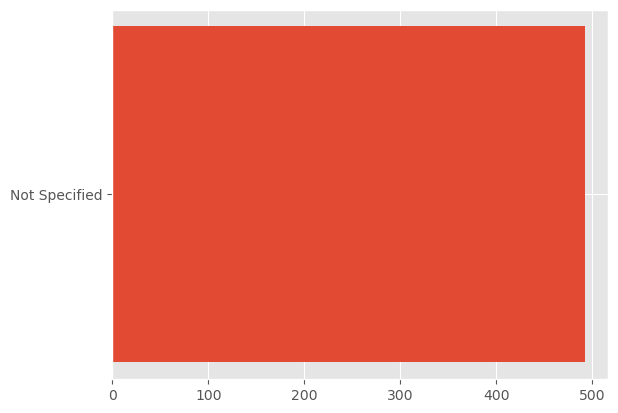

In [ ]:
converted_leads['lead_source'].value_counts()
x = converted_leads['lead_source'].value_counts().index
y = converted_leads['lead_source'].value_counts().values

plt.barh(x, y)

This shows that all converted leads show lead source as null. This may be an issue with how the backend data is collected. I'll revisit this in accounts and see if I can resolve for deeper insights.

In [ ]:
converted_leads.loc[converted_leads['lead_status'] != 'Enrolled']

,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
created_date,,,,,,
2011-08-11,1.0,Open,Converted,NaN,NaN,Not Specified
2014-06-05,10.0,Assessed,Converted,NaN,NaN,Not Specified
2017-01-07,1.0,Open,Converted,NaN,NaN,Not Specified
2017-02-04,NaN,Assessed,Converted,NaN,NaN,Not Specified
2017-06-30,15.0,Open,Converted,NaN,NaN,Not Specified
...,...,...,...,...,...,...
2023-09-21,20.0,Open,Converted,NaN,NaN,Not Specified
2023-10-12,5.0,Contacted,Converted,NaN,NaN,Not Specified
2023-10-19,32.0,Assessed,Converted,NaN,NaN,Not Specified


This shows a similar issue where not all converted accounts show an updated lead status of 'enrolled'. It could also indicate that these famiies were once enrolled but are not currently.

## Accounts

In [ ]:
stop

NameError: name 'stop' is not defined

### Encoding

In [ ]:
leads.columns

Index(['created_date', 'zip_code', 'lead_status', 'conversion_status',
       'student_gender', 'grade', 'lead_source'],
      dtype='object')

#### Lead Status

In [ ]:
leads['lead_status'].value_counts().index

Index(['Open', 'Mail Only', 'Assessed', 'Enrolled', 'Do Not Contact',
       'Visited', 'Contacted', 'Assessed - Declined Enrollment',
       'Assessment Pending', 'Hold'],
      dtype='object', name='lead_status')

In [ ]:
lead_status_map = {
    'Open': 1,
    'Contacted': 2,
    'Visited': 3,
    'Assessment Pending': 4,
    'Assessed': 5,
    'Assessed - Declined Enrollment': 6,
    'Enrolled': 7,
    'Hold': 8,
    'Mail Only': 9,
    'Do Not Contact': 10,
}

In [ ]:
leads['lead_status'] = leads['lead_status'].replace(lead_status_map)

#### Conversion Status

In [ ]:
leads['conversion_status'].value_counts().index

Index(['Unconverted', 'Converted'], dtype='object', name='conversion_status')

In [ ]:
conversion_status_map = {
    'Unconverted': 0,
    'Converted': 1
}

In [ ]:
leads['conversion_status'] = leads['conversion_status'].replace(conversion_status_map)

#### Student Gender

In [ ]:
leads['student_gender'].value_counts().index

Index(['Female', 'Male', 'Other'], dtype='object', name='student_gender')

In [ ]:
student_gender_map = {
    'Other': 0,
    'Female': 1,
    'Male': 2
}

In [ ]:
leads['student_gender'] = leads['student_gender'].replace(student_gender_map)

#### Grade

In [ ]:
leads['grade'].value_counts().index

Index(['College', '8', '9', '5', '10', '6', '7', '11', '12', '4', '2', '3',
       '1', 'K'],
      dtype='object', name='grade')

In [ ]:
grade_map = {
    'College': 13,
    'K': 0
}

In [ ]:
leads['grade'] = leads['grade'].replace(grade_map)

#### Lead Source

In [ ]:
leads['lead_source'].value_counts().index

Index(['Not Specified', 'Internet', 'Location', 'School', 'Referral', 'Other',
       'Direct Mail', 'Radio', 'TV', 'Previously Attended'],
      dtype='object', name='lead_source')

In [ ]:
lead_source_map = {
    'Not Specified': 0,
    'Previously Attended': 1,
    'Referral': 2,
    'Location': 3,
    'School': 4,
    'Events': 5,
    'Print': 6,                  # 'Media (Print, TV, Radio)'
    'TV': 6,
    'Radio': 6,
    'Direct Mail': 7,
    'Internet': 8,
    '3rd Party Site': 9,
    'Other': 10
}

In [ ]:
leads['lead_source'] = leads['lead_source'].replace(lead_source_map)

In [ ]:
# Check
leads.dtypes

created_date         datetime64[ns]
zip_code                    float64
lead_status                 float64
conversion_status             int64
student_gender              float64
grade                        object
lead_source                   int64
dtype: object

In [ ]:
leads.corr()

,created_date,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
created_date,1.000000,-0.102737,0.084457,-0.147050,0.259243,-0.401972,0.057571
zip_code,-0.102737,1.000000,-0.084823,0.008635,0.149141,-0.191069,0.014757
lead_status,0.084457,-0.084823,1.000000,-0.147757,0.293650,0.081753,0.116195
conversion_status,-0.147050,0.008635,-0.147757,1.000000,NaN,NaN,-0.732464
student_gender,0.259243,0.149141,0.293650,NaN,1.000000,0.056376,-0.063242
grade,-0.401972,-0.191069,0.081753,NaN,0.056376,1.000000,0.024218
lead_source,0.057571,0.014757,0.116195,-0.732464,-0.063242,0.024218,1.000000


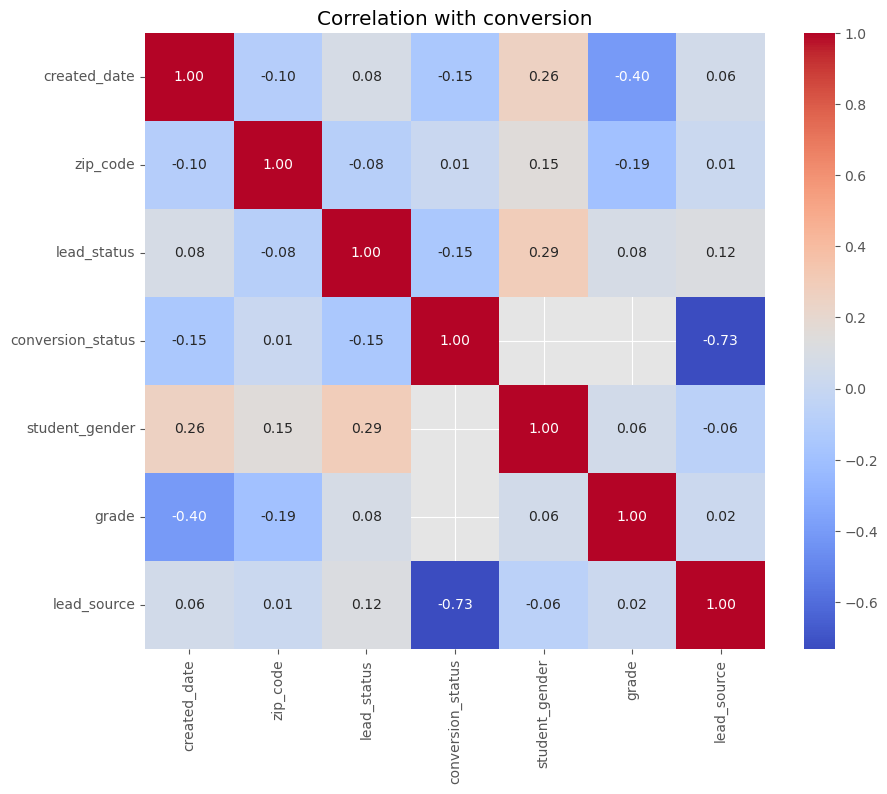

In [ ]:
# Calculate correlation matrix
correlation_matrix = leads.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(leads.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation with conversion')
plt.show()


### Summary of Data Findings

## Potential Routes of Analysis


## Chosen Metrics for Analysis


## Data Cleaning & Feature Engineering

## Analysis

### Direction 1


#### Direction 1 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 1:

### Direction 2


#### Direction 2 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 2:

### Direction 3

#### Direction 3 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 3:

## Results


### Direction 1
* 


### Direction 2
* 


### Direction 3
* 

## Conclusions
This analysis leads to three recommendations.

1. 

2. 

3. 

## Next Steps
* 